In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Input, Dropout, Embedding
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant

import warnings
warnings.filterwarnings("ignore")

Dataset: https://www.kaggle.com/datasets/nelgiriyewithana/emotions/code

In [2]:
data = pd.read_csv('data/text.csv', index_col=0)
data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

### Data description, visualization and statistical analysis

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ MB
None


In [4]:
missing_values = data.isnull().sum()
print(f"Missing values:\n{missing_values}")

duplicate_entries = data.duplicated().sum()
print(f"Duplicate entries: {duplicate_entries}")

Missing values:
text     0
label    0
dtype: int64
Duplicate entries: 686


In [5]:
for i in range(min(5, len(data))):
    print(data['text'].iloc[i], "\n")

i just feel really helpless and heavy hearted 

ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing 

i gave up my internship with the dmrg and am feeling distraught 

i dont know i feel so lost 

i am a kindergarten teacher and i am thoroughly weary of my job after having taken the university entrance exam i suffered from anxiety for weeks as i did not want to carry on with my work studies were the only alternative 



In [6]:
data = data.drop_duplicates()

### Data sentiment

In [7]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [8]:
data['polarity'] = data['text'].apply(polarity)
data.head()

,text,label,polarity
0,i just feel really helpless and heavy hearted,4,0.000
1,ive enjoyed being able to slouch about relax a...,0,0.025
2,i gave up my internship with the dmrg and am f...,4,-0.600
3,i dont know i feel so lost,0,0.000
4,i am a kindergarten teacher and i am thoroughl...,4,0.000


In [9]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [10]:
data['sentiment'] = data['polarity'].apply(sentiment)
data.head()

,text,label,polarity,sentiment
0,i just feel really helpless and heavy hearted,4,0.000,Neutral
1,ive enjoyed being able to slouch about relax a...,0,0.025,Positive
2,i gave up my internship with the dmrg and am f...,4,-0.600,Negative
3,i dont know i feel so lost,0,0.000,Neutral
4,i am a kindergarten teacher and i am thoroughl...,4,0.000,Neutral


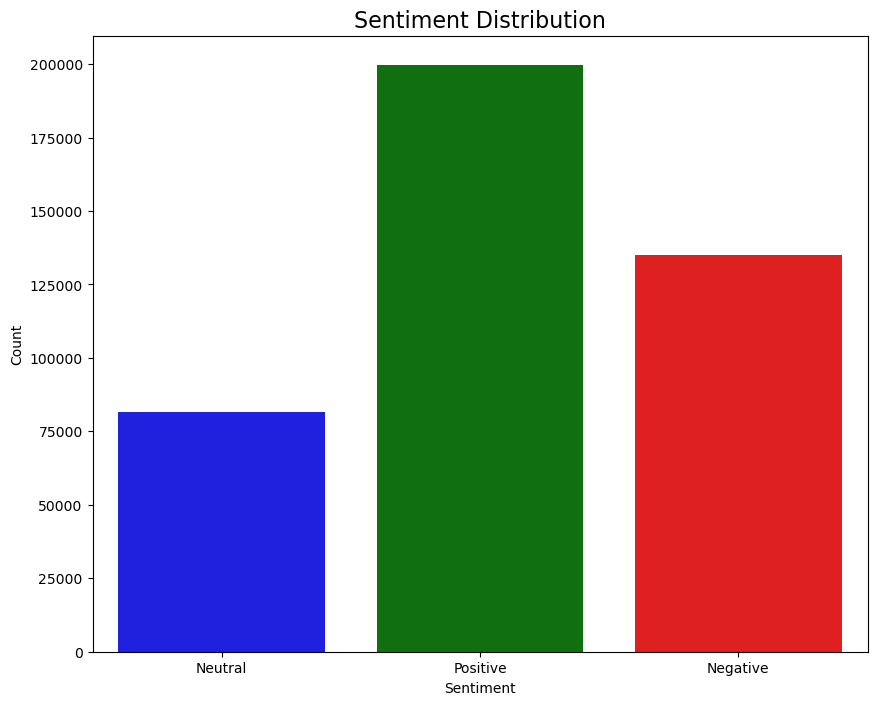

In [11]:
palette = {"Negative": "red", "Neutral": "blue", "Positive": "green"}

plt.figure(figsize=(10, 8))
sns.countplot(x='sentiment', data=data, palette=palette)
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

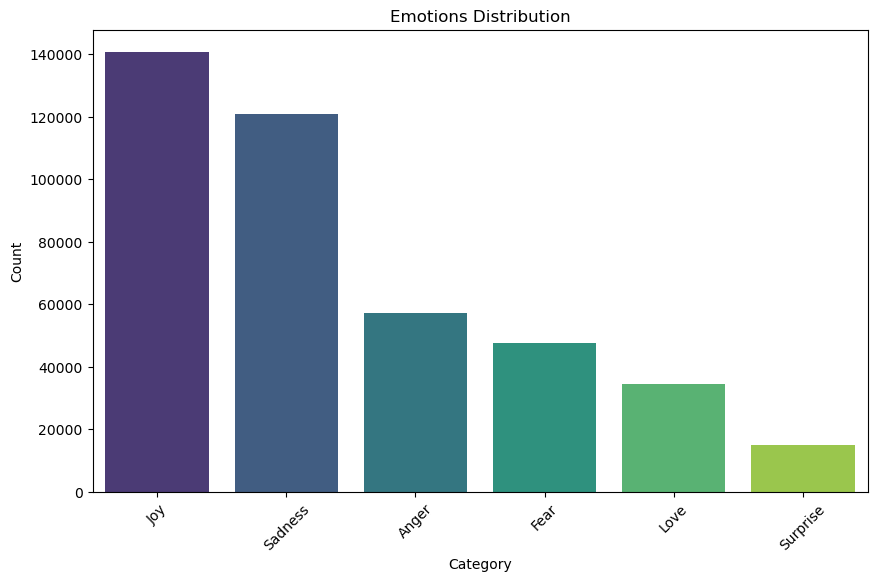

In [12]:
category_dict = {0: "Sadness", 1: "Joy", 2: "Love", 3: "Anger", 4: "Fear", 5: "Surprise"}
data["Category"] = data["label"].map(category_dict)
label_counts = data["Category"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Emotions Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [13]:
group_counts = data['label'].value_counts()
print(group_counts)

label
1    140779
0    120989
3     57235
4     47664
2     34497
5     14959
Name: count, dtype: int64


In [14]:
min_count = group_counts.min()
balanced_df = data.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
print(balanced_df['label'].value_counts())

label
0    14959
1    14959
2    14959
3    14959
4    14959
5    14959
Name: count, dtype: int64


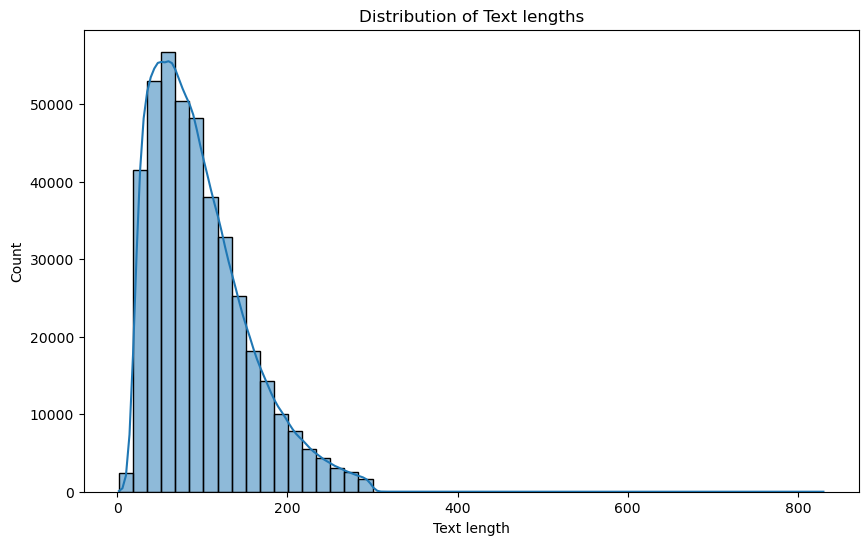

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(data['text'].apply(len), bins=50, kde=True)
plt.title('Distribution of Text lengths')
plt.xlabel('Text length')
plt.ylabel('Count')
plt.show()

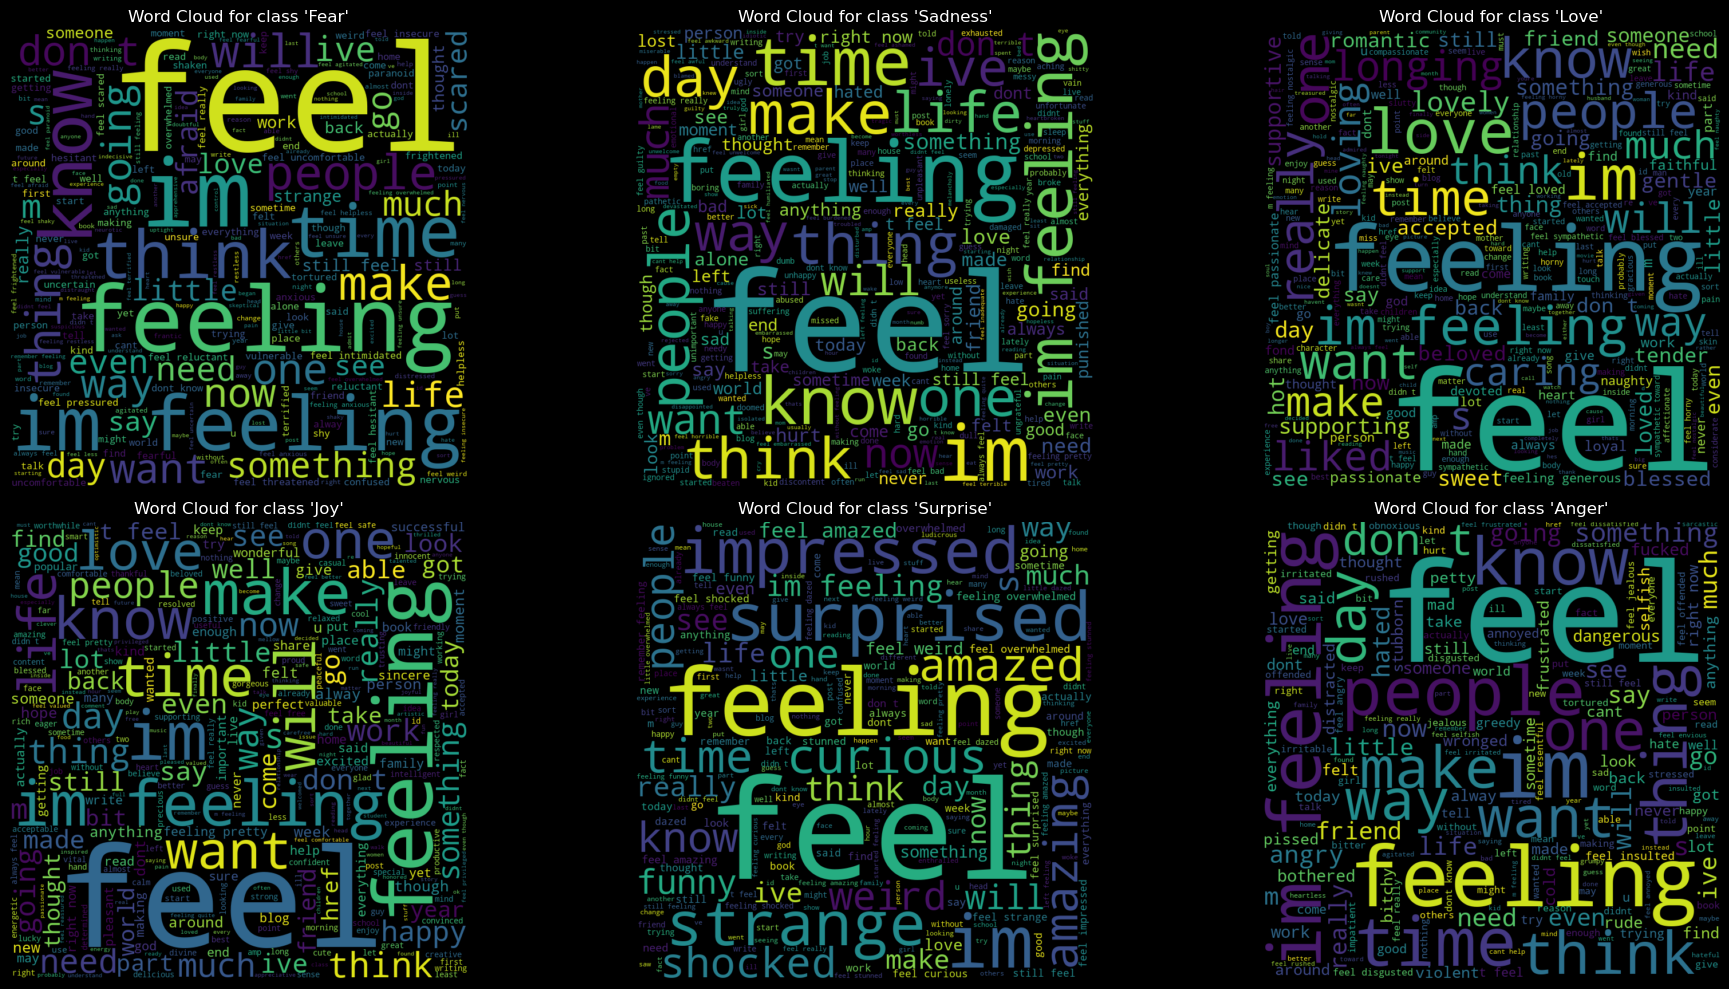

In [16]:
def generate_wordcloud(text, ax, title):
    wordcloud = WordCloud(width=800, height=800, 
                          background_color='black', 
                          stopwords=None, 
                          max_words=400,
                          min_font_size=10).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, color='white')
    ax.axis("off")

fig, axs = plt.subplots(2, 3, figsize=(20, 10), facecolor='black')

for i, label in enumerate(data['label'].unique()):
    text = ' '.join(data[data['label'] == label]['text'])
    row = i // 3
    col = i % 3
    generate_wordcloud(text, axs[row, col], f"Word Cloud for class '{category_dict[label]}'")

plt.tight_layout()
plt.show()

### Data preprocessing

In [17]:
stop_words = stopwords.words('english')

def data_cleaning(text):

    # Convert to lower
    text = text.lower()
    
    remove_stopwords = [word for word in text.split() if word not in stop_words]
    text = ' '.join(remove_stopwords)
    
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    text = re.sub(r"\d", '', text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)
    
    return text

In [18]:
data['cleaned_text'] = data['text'].apply(data_cleaning)

In [19]:
X = data['cleaned_text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_text'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
max_length = data['cleaned_text'].apply(lambda x: len(str(x).split())).max()

In [21]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

X_train.shape, X_test.shape

((332898, 79), (83225, 79))

In [22]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [23]:
GLOVE_EMB = 'data/glove.6B.300d.txt'

embeddings_index = {}

f = open(GLOVE_EMB , encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

EMBEDDING_DIM = 300
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

Found 400000 word vectors.


In [24]:
embedding_layer = Embedding(
    vocab_size,
    EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_length,
    trainable=False)

In [25]:
sequence_input = Input(shape=(X_train.shape[1],))
embedding_sequences = embedding_layer(sequence_input)

x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(embedding_sequences)
outputs = Dense(6, activation='softmax')(x)

model = Model(sequence_input, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 79)]              0         
                                                                 
 embedding (Embedding)       (None, 79, 300)           22545300  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 22,732,954
Trainable params: 187,654
Non-trainable params: 22,545,300
_________________________________________________________________


In [26]:
# Limited to 5 epochs due to time and resource constraints. You can increase number of epochs.
history = model.fit(X_train , y_train, validation_split=0.2, epochs=5)

Epoch 1/5
8323/8323 [==============================] - 2652s 318ms/step - loss: 0.2469 - accuracy: 0.8955 - val_loss: 0.1161 - val_accuracy: 0.9337
Epoch 2/5
8323/8323 [==============================] - 2591s 311ms/step - loss: 0.1152 - accuracy: 0.9353 - val_loss: 0.1021 - val_accuracy: 0.9359
Epoch 3/5
8323/8323 [==============================] - 2768s 333ms/step - loss: 0.1062 - accuracy: 0.9378 - val_loss: 0.1001 - val_accuracy: 0.9368
Epoch 4/5
8323/8323 [==============================] - 2569s 309ms/step - loss: 0.0991 - accuracy: 0.9399 - val_loss: 0.0998 - val_accuracy: 0.9360
Epoch 5/5
8323/8323 [==============================] - 2568s 308ms/step - loss: 0.0961 - accuracy: 0.9408 - val_loss: 0.0979 - val_accuracy: 0.9374


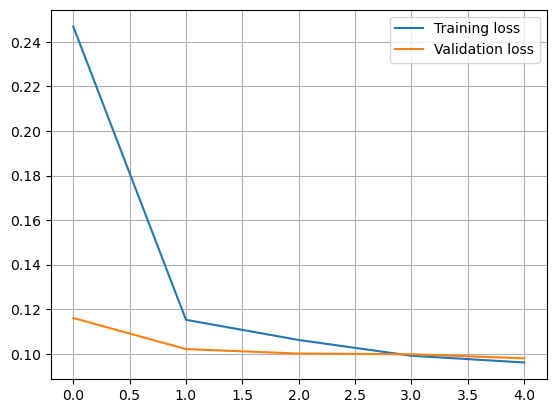

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")

plt.legend()
plt.grid()
plt.show()

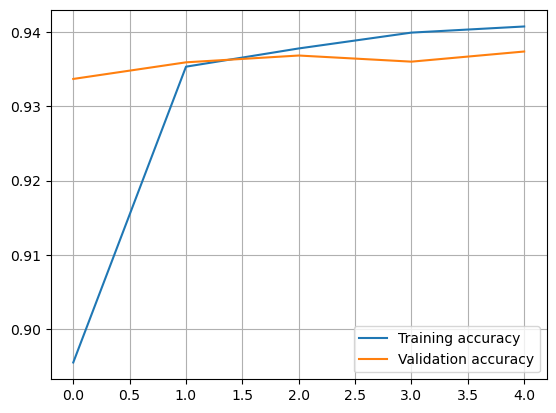

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy, label="Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")

plt.legend()
plt.grid()
plt.show()

In [29]:
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis=1)

# Convert y_test from one-hot encoded format like [0 0 1 0 0 0] to categorical labels by selecting the index with the highest value
y_test = np.argmax(y_test, axis=1)

print(accuracy_score(y_pred, y_test))

2601/2601 [==============================] - 148s 57ms/step
0.9366296185040552
